# Analyse correlations in alignment of reads to human and arabidopsis

This notebook performs an analysis of a pair of full BAM files, one aligned to human genome and one to Arabidopsis.




* Run the bash script before using this notebook.

## Supporting code

In [1]:
import pysam
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pysam'

## Code from "small fragments" -- do we need it here?

In [2]:
def get_read_pairs(bam, want_n_pairs, print_qname=False):
    reads = []
    for count, r in enumerate( bam.fetch()):
        if not r.is_read1 or r.mapping_quality < 20 or not r.is_proper_pair:
            continue
        try:
            m8 = bam.mate(r)
        except ValueError:
            continue
        if m8.mapping_quality < 20 or abs(m8.reference_start - r.reference_start) > 3000:
            continue
        if print_qname:
            print("\n", r.query_name)
        reads.append((r, m8))
        if len(reads) == want_n_pairs:
            break
    return reads

In [3]:
sample = "NEB-100ng-1"
tags = ['arabidopsis', 'human']
bams = [pysam.AlignmentFile(f"data/{sample}-{tag}-qsort.bam") for tag in tags]

NameError: name 'pysam' is not defined

In [17]:
def next_valid_read(it):
    for r in it:
        if r.is_read1 and r.is_proper_pair and r.mapping_quality >= 20 and not r.is_secondary:
            return r
    return None

In [54]:
iters = [bam.fetch(until_eof=True) for bam in bams]
current_read = [None, next_valid_read(iters[1])]

# The list position acts as an index into arrays iters, current_read, etc.
# It allows to swap around the files and all corresponding values.

# **The file in the first position should always be the one with a queryname sorting before,
# that is a "lower" query name.**
position = [0, 1]
# All other arrays stay fixed and are referenced through the position array.

MAX_LEN = 1000
size_corr = np.zeros((MAX_LEN, MAX_LEN))
unique = [0, 0]
both = 0

counter = 0

while current_read[1]:
    current_read[position[0]] = next_valid_read(iters[position[0]])
    if not current_read[position[0]]:
        break
    elif current_read[position[0]].query_name > current_read[position[1]].query_name:
        # We found a greater one in the current iterator (which was behind before).
        # Mark the read with qname less, in iterator index 1, as unique to that file.
        unique[position[1]] += 1
        # Then swap the order.
        stats_object = position[1:] + position[:1]
    elif current_read[0].query_name == current_read[1].query_name:
        lengths = [min(9999, abs(current_read[position[x]].tlen)) for x in [0,1]]
        size_corr[lengths] += 1
        both += 1
        current_read[position[1]] = next_valid_read(iters[position[1]])
    else:
        # Our current iterator is still behind. The read we just processed was unique to our file.
        unique[position[0]] += 1
    counter += 1
    if counter % 1000000 == 0:
        print("Processed", counter, "raw reads")

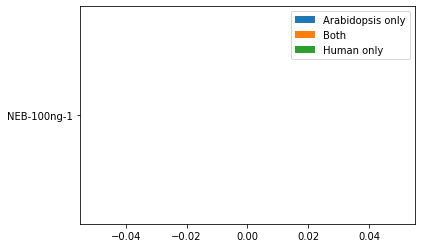

In [16]:
plt.barh([sample], [unique[0]], label="Arabidopsis only")
plt.barh([sample], [both], label="Both")
plt.barh([sample], [unique[1]], label="Human only")
plt.xlabel("High-quality read pairs")
plt.legend()

In [46]:
def rebin(squareHist, factor):
    (nx0, ny0) = squareHist.shape
    return sum(
        squareHist[i::factor, j::factor]
        for i in range(factor)
        for j in range(factor)
    )

In [51]:
rebin_factor = 250
z = rebin(size_corr, rebin_factor)
x = list(range(0, size_corr.shape[1]+1, rebin_factor))
y = list(range(0, size_corr.shape[0]+1, rebin_factor))

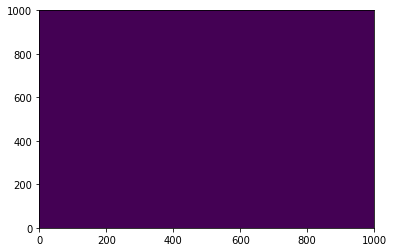

In [52]:
plt.pcolormesh(x, y, z)